## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Data preprocessing

### Read data

In [2]:
stock_ctlt = pd.read_csv('../../../Dataset/CTLT.csv')
stock_ctlt

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


### Reset index

In [3]:
# Convert the 'Date' column to datetime format
stock_ctlt['Date'] = pd.to_datetime(stock_ctlt['Date'])

# Set the 'Date' column as the index value
stock_ctlt = stock_ctlt.set_index(pd.DatetimeIndex(stock_ctlt['Date'].values))

# Create new datafram with Date and Close
df_ctlt = pd.DataFrame(stock_ctlt, columns=['Close'])

### Data normalization

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
df_ctlt = scaler.fit_transform(np.array(df_ctlt).reshape(-1,1))

### Data splitting

In [5]:
# Length
    # Train: 70%
    # Val: 10%
    # Test: 20%
train_size = int(len(df_ctlt) * 0.7)
val_size = int(len(df_ctlt) * 0.1)
test_size = len(df_ctlt) - train_size - val_size

In [6]:
# Get Data 
train_data = df_ctlt[:train_size]
val_data = df_ctlt[train_size:train_size+val_size]
test_data = df_ctlt[train_size+val_size:]

In [7]:
# Create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step):
		a = dataset[i:(i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [8]:
# Reshape into X=t,t+1,t+2..t+100 and Y=t+100
time_step = 100

# Get lost data for test
val_last_windowsize = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data_extended, time_step)

In [9]:
# Make input for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

## Model training and testing

In [10]:
# Define model
    # Pack the sequence of the inner layers
model = Sequential()
    # LSTM with 64 units with reture_sequences = true => preidct along to the series
model.add(LSTM(64, return_sequences=True, input_shape = (time_step, 1)))
    # LSTM with 64 units with reture_sequences = false => get the last predict
model.add(LSTM(64, return_sequences=False, input_shape = (time_step, 1)))
    # Dropout: Avoid remembering too much information => disable part of the previous data
model.add(Dropout(0.2))
    # 1 Dense layer (dense): 1 unit provides predictive value, using activiation function: relu
model.add(Dense(1,activation='relu'))
    # Compile model with loss function: MST, optimize: adam 
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
# Using earlystopping to prevent overfitting
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [12]:
# Training LSTM model
model.fit(X_train, y_train, validation_data=(X_val, yval), epochs = 100, batch_size = 64,verbose = 1,  callbacks=earlystop)

Epoch 1/100


11/11 [==============================] - 19s 609ms/step - loss: 0.1230 - val_loss: 0.0172
Epoch 2/100
11/11 [==============================] - 3s 267ms/step - loss: 0.0176 - val_loss: 0.0076
Epoch 3/100
11/11 [==============================] - 3s 251ms/step - loss: 0.0087 - val_loss: 0.0042
Epoch 4/100
11/11 [==============================] - 3s 256ms/step - loss: 0.0069 - val_loss: 0.0018
Epoch 5/100
11/11 [==============================] - 4s 328ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 6/100
11/11 [==============================] - 3s 257ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 7/100
11/11 [==============================] - 3s 235ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 8/100
11/11 [==============================] - 3s 247ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 9/100
11/11 [==============================] - 3s 282ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 10/100
11/11 [==============================] - 4s 369ms/step - loss: 0.0036 - val_loss: 0.0022


### Testing process

In [13]:
# Predict
y_pred = model.predict(X_test)

8/8 [==============================] - 3s 62ms/step


### Evaluate model

In [14]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"Testing MAPE: ", test_mape)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.17517328667139603
Testing RMSE:  0.06155043785784311
Testing MSLE:  0.0023648466627907362


## Predicting the next 30 days

### Preparing the prediction data

In [15]:
x_input = test_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)

        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat[0].tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [16]:
# Print predict next 30 days
print(prediction_next30_days)

[[0.08390402793884277], [0.08745596557855606], [0.09049081057310104], [0.09310945868492126], [0.09540962427854538], [0.09747591614723206], [0.09937648475170135], [0.10116338729858398], [0.10287465900182724], [0.10453710705041885], [0.10616888105869293], [0.10778184980154037], [0.10938357561826706], [0.11097850650548935], [0.11256936192512512], [0.11415760219097137], [0.11574407666921616], [0.11732912063598633], [0.11891306936740875], [0.1204959973692894], [0.1220780536532402], [0.12365934252738953], [0.1252399981021881], [0.12682011723518372], [0.12839984893798828], [0.12997928261756897], [0.13155853748321533], [0.13313770294189453], [0.13471689820289612], [0.13629618287086487]]


### Preparing the forecast date index

In [17]:
# Get the last date from the current index
last_date = stock_ctlt.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [18]:
# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)

In [19]:
# Convert to normal values
y_pred = scaler.inverse_transform(y_pred)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

## Visualization

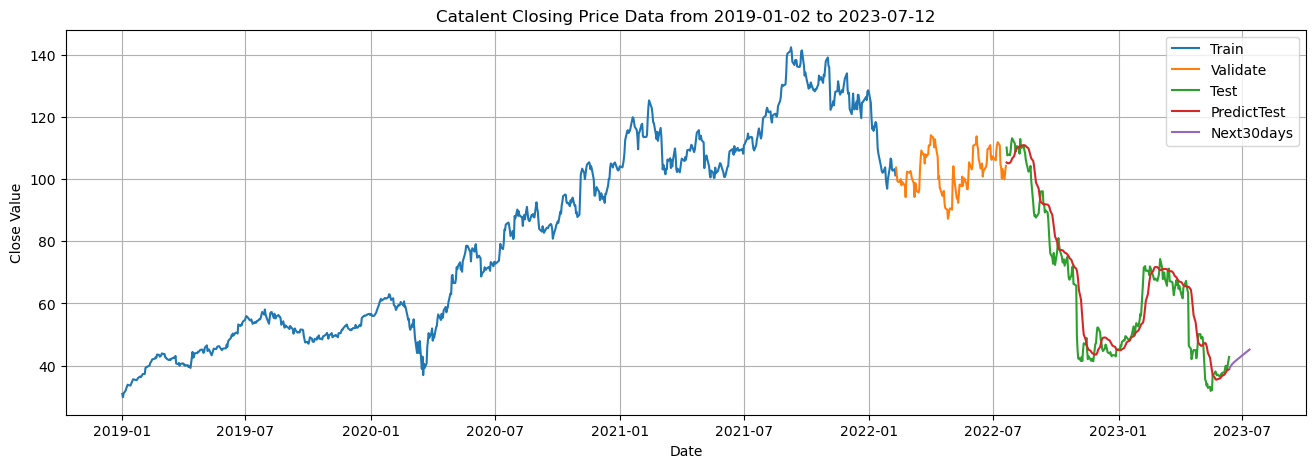

In [20]:
plt.figure(figsize=(16,5))

plt.plot(stock_ctlt.index[:train_size], train_data)

plt.plot(stock_ctlt.index[train_size:train_size + val_size],val_data)

plt.plot(stock_ctlt.index[train_size + val_size: ], test_data)

plt.plot(stock_ctlt.index[train_size + val_size: ],(y_pred))

plt.plot(future_dates, prediction_next30_days)

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Catalent Closing Price Data from 2019-01-02 to 2023-07-12')
plt.legend(['Train','Validate','Test','PredictTest','Next30days'])
plt.grid()
plt.savefig('../Image/LSTM_712_CTLT.png')
plt.show()